In [157]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import numpy as np
import seaborn as sn
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

In [158]:
df = pd.read_csv('data.csv')
df

,SALE_DT,STORE,SALES
0,2019-01-01 00:00:00.000,Store_a,0.00
1,2019-01-02 00:00:00.000,Store_a,16553359.58
2,2019-01-03 00:00:00.000,Store_a,17956624.58
3,2019-01-04 00:00:00.000,Store_a,19440652.23
4,2019-01-05 00:00:00.000,Store_a,20677704.73
...,...,...,...
1272,2022-06-26 00:00:00.000,Store_a,17243093.78
1273,2022-06-27 00:00:00.000,Store_a,13538082.87
1274,2022-06-28 00:00:00.000,Store_a,13565274.83
1275,2022-06-29 00:00:00.000,Store_a,14959597.22


In [159]:
df.isnull().sum()

SALE_DT    0
STORE      0
SALES      0
dtype: int64

In [160]:
df.columns = ['date', 'store','sales']
df.head()

,date,store,sales
0,2019-01-01 00:00:00.000,Store_a,0.00
1,2019-01-02 00:00:00.000,Store_a,16553359.58
2,2019-01-03 00:00:00.000,Store_a,17956624.58
3,2019-01-04 00:00:00.000,Store_a,19440652.23
4,2019-01-05 00:00:00.000,Store_a,20677704.73


In [198]:
# Filter records for store 1 and item 1 -> to be able to scale to other items in the future
# df = df[df['store'] == 1]
# df = df[df['item'] == 1]

# df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') # convert date column to datatime object
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d') # convert date column to datatime object

# # Create Date-related Features to be used for EDA and Supervised ML: Regression
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekday'] = np.where(df.weekday == 0, 7, df.weekday)
#
# # Split the series to predict the last 3 months of 2017
temp_df = df.set_index('date')
train_df = temp_df.loc[:'2022-03-29'].reset_index(drop=False)
test_df = temp_df.loc['2022-03-30':].reset_index(drop=False)
#
df

,date,store,sales,year,month,day,weekday
0,2019-01-01,Store_a,0.00,2019,1,1,1
1,2019-01-02,Store_a,16553359.58,2019,1,2,2
2,2019-01-03,Store_a,17956624.58,2019,1,3,3
3,2019-01-04,Store_a,19440652.23,2019,1,4,4
4,2019-01-05,Store_a,20677704.73,2019,1,5,5
...,...,...,...,...,...,...,...
1272,2022-06-26,Store_a,17243093.78,2022,6,26,6
1273,2022-06-27,Store_a,13538082.87,2022,6,27,7
1274,2022-06-28,Store_a,13565274.83,2022,6,28,1
1275,2022-06-29,Store_a,14959597.22,2022,6,29,2


In [199]:
train_df.tail()

,date,store,sales,year,month,day,weekday
1179,2022-03-25,Store_a,22328937.01,2022,3,25,4
1180,2022-03-26,Store_a,29589192.27,2022,3,26,5
1181,2022-03-27,Store_a,24579735.38,2022,3,27,6
1182,2022-03-28,Store_a,15078616.15,2022,3,28,7
1183,2022-03-29,Store_a,15796594.38,2022,3,29,1


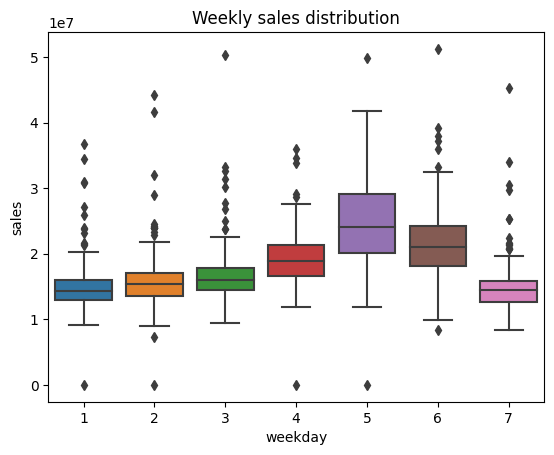

In [200]:
plot = sn.boxplot(x='weekday', y='sales', data=df)
_ = plot.set(title='Weekly sales distribution')

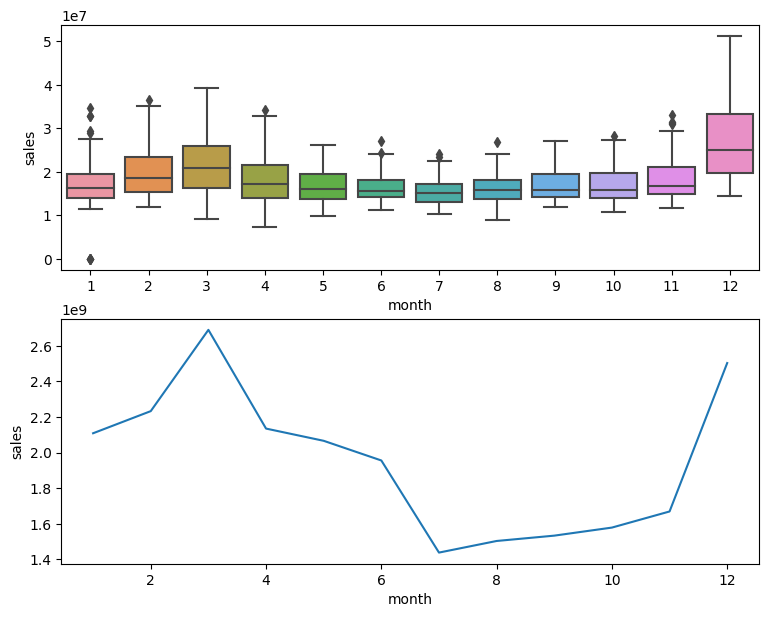

In [201]:
monthly_agg = df.groupby('month')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='month', y='sales', data=df, ax=axs[0])
_ = sn.lineplot(x='month', y='sales', data=monthly_agg, ax=axs[1])

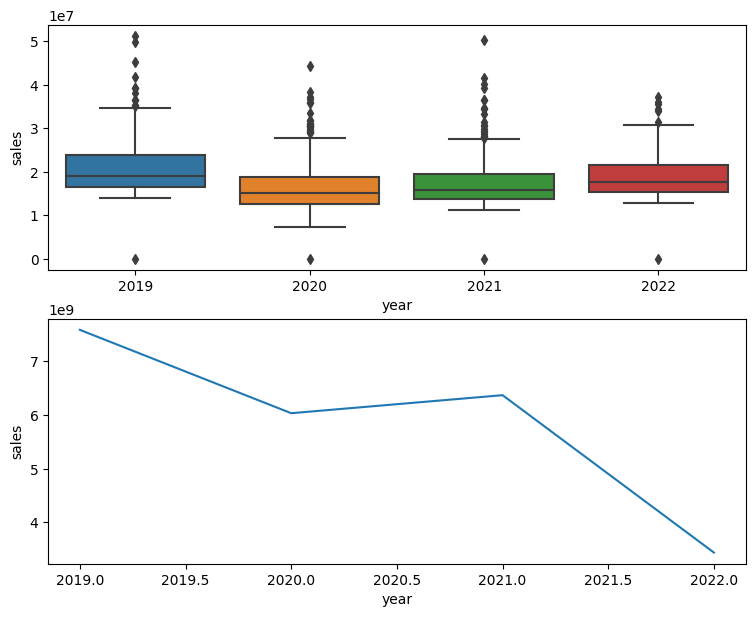

In [202]:
yearly_agg = df.groupby('year')['sales'].sum().reset_index()
fig, axs = plt.subplots(nrows=2, figsize=(9,7))
sn.boxplot(x='year', y='sales', data=df, ax=axs[0])
_ = sn.lineplot(x='year', y='sales', data=yearly_agg, ax=axs[1])

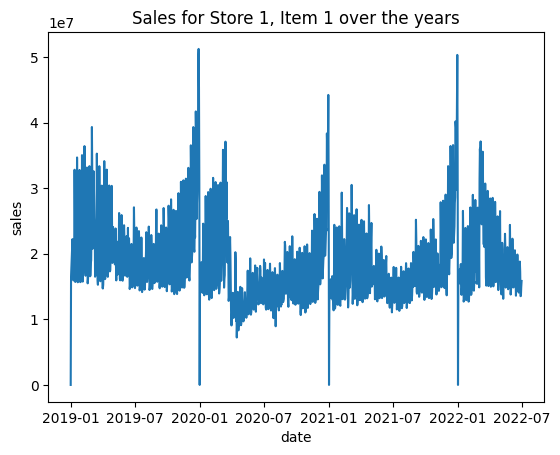

In [203]:
plot = sn.lineplot(x='date', y='sales', data=df)
_ = plot.set(title='Sales for Store 1, Item 1 over the years')

In [204]:
# subtract 1 year from test data
dates = (test_df['date'] - np.timedelta64(1, 'Y') + \
        np.timedelta64(1, 'D')).values.astype('datetime64[D]')
seasonal_naive_sales = train_df[train_df['date'].astype('datetime64[ns]').isin(dates)]['sales']

# # make a copy of the test_df and make naive predictions for the last 3 months of 2017
sn_pred_df = test_df.copy().drop('sales', axis=1)
sn_pred_df['seasonal_naive_sales'] = pd.DataFrame(seasonal_naive_sales).set_index(test_df.index)
sn_pred_df.head()

,date,store,year,month,day,weekday,seasonal_naive_sales
0,2022-03-30,Store_a,2022,3,30,2,12976370.20
1,2022-03-31,Store_a,2022,3,31,3,14436502.63
2,2022-04-01,Store_a,2022,4,1,4,18519502.87
3,2022-04-02,Store_a,2022,4,2,5,25172470.11
4,2022-04-03,Store_a,2022,4,3,6,20964365.60


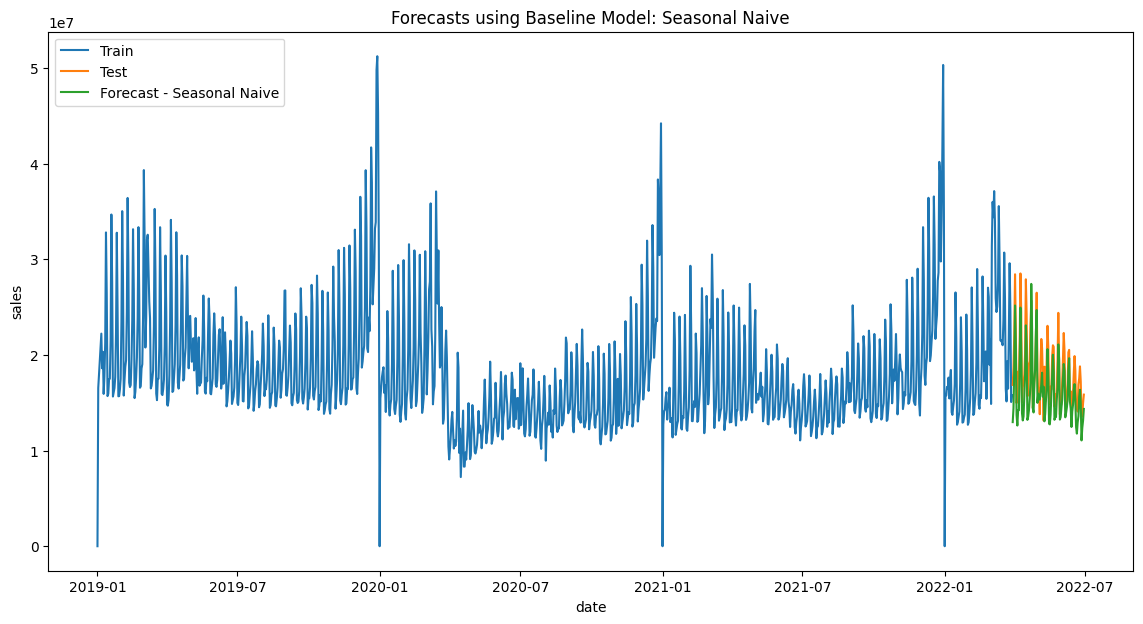

In [205]:
plt.figure(figsize=(14,7))
plt.plot(train_df['date'], train_df['sales'], label='Train')
plt.plot(test_df['date'], test_df['sales'], label='Test')
plt.plot(sn_pred_df['date'], sn_pred_df['seasonal_naive_sales'], label='Forecast - Seasonal Naive')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Forecasts using Baseline Model: Seasonal Naive')
plt.show()

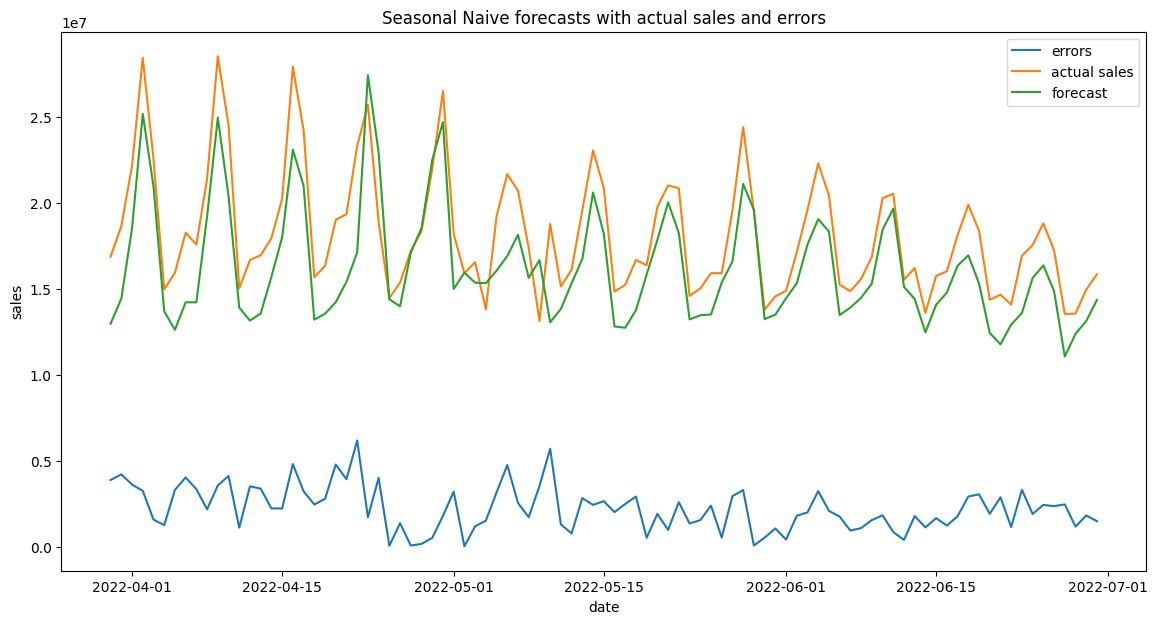

,total_sales,total_sn_pred_sales,overall_error,MAE,RMSE,MAPE
model,,,,,,
Seasonal Naive,1.691730e+09,1.506562e+09,1.851678e+08,2.241222e+06,2.586054e+06,12.320741


In [206]:
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'sales', 'seasonal_naive_sales']]
errors_df = pd.merge(test_df, sn_pred_df, on='date')
errors_df = errors_df[['date', 'sales', 'seasonal_naive_sales']]
errors_df['errors'] = test_df['sales'] - sn_pred_df['seasonal_naive_sales']
errors_df.insert(0, 'model', 'Seasonal Naive')

def mae(err):
    return np.mean(np.abs(err))

def rmse(err):
    return np.sqrt(np.mean(err ** 2))

def mape(err, sales=errors_df['sales']):
    return np.sum(np.abs(err))/np.sum(sales) * 100

result_df = errors_df.groupby('model').agg(total_sales=('sales', 'sum'),
                                           total_sn_pred_sales=('seasonal_naive_sales', 'sum'),
                                           overall_error=('errors', 'sum'),
                                           MAE=('errors', mae),
                                           RMSE=('errors', rmse),
                                           MAPE=('errors', mape))


plt.figure(figsize=(14,7))
plt.plot(errors_df['date'], np.abs(errors_df['errors']), label='errors')
plt.plot(errors_df['date'], errors_df['sales'], label='actual sales')
plt.plot(errors_df['date'], errors_df['seasonal_naive_sales'], label='forecast')
plt.legend(loc='best')
plt.xlabel('date')
plt.ylabel('sales')
plt.title('Seasonal Naive forecasts with actual sales and errors')
plt.show()

result_df

In [207]:
ts_decomp_df = train_df.set_index('date') # set date as index
ts_decomp_df['sales'] = ts_decomp_df['sales'].astype(float)
ts_decomp_df.head()

,store,sales,year,month,day,weekday
date,,,,,,
2019-01-01,Store_a,0.00,2019,1,1,1
2019-01-02,Store_a,16553359.58,2019,1,2,2
2019-01-03,Store_a,17956624.58,2019,1,3,3
2019-01-04,Store_a,19440652.23,2019,1,4,4
2019-01-05,Store_a,20677704.73,2019,1,5,5


<Figure size 640x480 with 0 Axes>

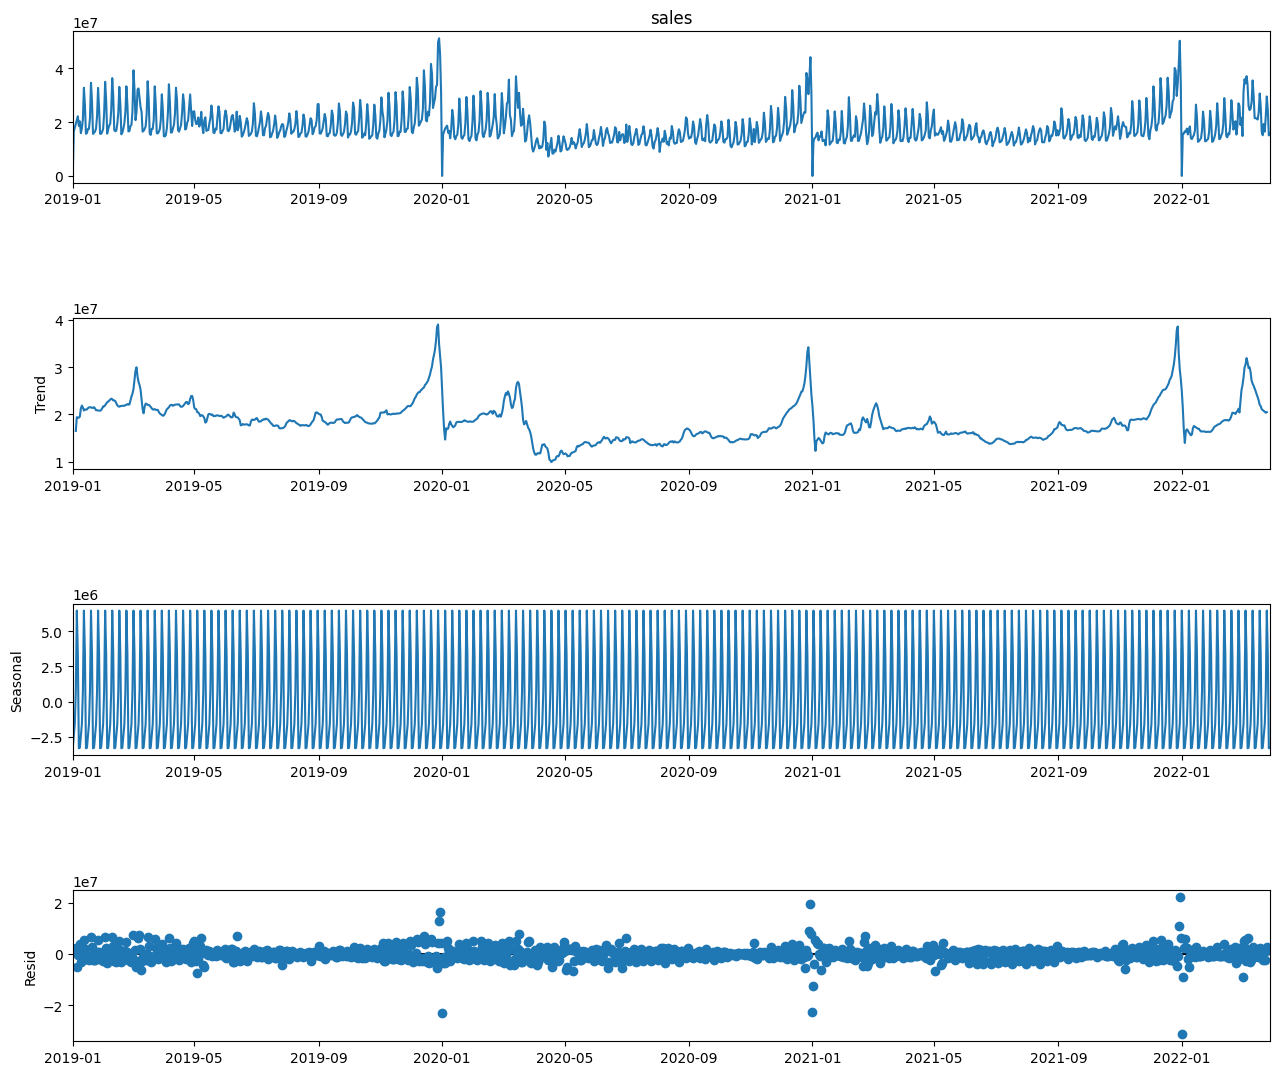

In [212]:
result = seasonal_decompose(ts_decomp_df['sales'], model='additive')
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(14, 12)

In [215]:
hw_train_df = train_df[['date', 'sales']].set_index('date')
hw_test_df = test_df[['date', 'sales']].set_index('date')

# Apply Triple Exponential Smoothing

hw_model_1 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12)
hw_fit_1 = hw_model_1.fit(use_boxcox=False, remove_bias=False)
pred_fit_1 = pd.Series(hw_fit_1.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]),
                       name='pred_sales').reset_index()
#
# hw_model_2 = ExponentialSmoothing(hw_train_df, trend='add', seasonal='add', seasonal_periods=12, damped=True)
# hw_fit_2 = hw_model_2.fit(use_boxcox=False, remove_bias=False)
# pred_fit_2 = pd.Series(hw_fit_2.predict(start=hw_test_df.index[0], end=hw_test_df.index[-1]),
#                        name='pred_sales').reset_index()
# print('Forecasts made, ready for evaluation')

ValueError: use_boxcox was set at model initialization and cannot be changed